101002 - Justin Tuyisenge

# Importing Libraries

In [47]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Data Loading and Cleaning

In [48]:
# 2: Data Loading and Cleaning
def load_and_clean_data(file_path):
    """Enhanced data loading and cleaning with better error handling"""
    try:
        df_raw = pd.read_csv(file_path, skiprows=3)
        print("Raw DataFrame Columns:", df_raw.columns.tolist())
        print(f"Raw DataFrame Shape: {df_raw.shape}")
        
        expected_id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
        id_vars = [col for col in expected_id_vars if col in df_raw.columns]
        
        missing_vars = [col for col in expected_id_vars if col not in df_raw.columns]
        if missing_vars:
            print(f"Warning: The following id_vars are missing: {missing_vars}")
        
        if not id_vars:
            raise KeyError("No valid id_vars found in the DataFrame.")
        
        df_raw = df_raw.dropna(how='all').reset_index(drop=True)
        df_raw = df_raw.loc[:, ~df_raw.columns.str.contains('^Unnamed')]
        
        value_vars = [col for col in df_raw.columns if str(col).isdigit()]
        if not value_vars:
            raise ValueError("No year columns found in the dataset.")
        
        print(f"Found {len(value_vars)} year columns: {value_vars[:5]}...{value_vars[-5:]}")
        
        df_long = df_raw.melt(id_vars=id_vars, value_vars=value_vars, 
                             var_name='Year', value_name='Value')
        
        df_long['Year'] = df_long['Year'].astype(int)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
        df_long.dropna(subset=['Value'], inplace=True)
        
        df_wide = df_long.pivot_table(index='Year', columns='Indicator Name', values='Value')
        
        missing_threshold = 0.7
        df_wide = df_wide.dropna(axis=1, thresh=missing_threshold * len(df_wide))
        df_wide = df_wide.dropna(axis=0, thresh=0.5 * len(df_wide.columns))
        df_wide = df_wide.ffill().bfill()
        
        print(f"\nCleaned DataFrame Shape: {df_wide.shape}")
        print(f"Years covered: {df_wide.index.min()} to {df_wide.index.max()}")
        
        return df_wide
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Exploratory Data Analysis

In [49]:
# 3: Exploratory Data Analysis
def perform_eda(df_wide, target_column):
    """Comprehensive EDA with visualizations"""
    os.makedirs('figures', exist_ok=True)
    
    key_indicators = [
        'Merchandise exports by the reporting economy (current US$)',
        'Population ages 65 and above (% of total population)',
        'Net financial flows, multilateral (NFL, current US$)',
        'Gross capital formation (current US$)',
        'Adjusted savings: education expenditure (current US$)'
    ]
    
    available_indicators = [col for col in key_indicators if col in df_wide.columns]
    if len(available_indicators) < 3:
        target_corr = df_wide.corr()[target_column].abs().sort_values(ascending=False)
        available_indicators = target_corr.head(6).index.tolist()
        available_indicators = [col for col in available_indicators if col != target_column][:5]
    
    print(f"Using indicators for EDA: {available_indicators}")
    
    # Time-series Plot
    plt.figure(figsize=(8, 6))
    plt.plot(df_wide.index, df_wide[target_column], marker='o', linewidth=2, markersize=4)
    z = np.polyfit(df_wide.index, df_wide[target_column], 1)
    p = np.poly1d(z)
    plt.plot(df_wide.index, p(df_wide.index), "r--", alpha=0.8, label='Trend')
    plt.title('Time-series of Merchandise Exports (1961–2023)', fontsize=12, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Exports (current US$)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/timeseries.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Distribution Plot
    plt.figure(figsize=(8, 6))
    plt.hist(df_wide[target_column], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(df_wide[target_column].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_wide[target_column].mean():.2e}')
    plt.axvline(df_wide[target_column].median(), color='green', linestyle='--', 
                label=f'Median: {df_wide[target_column].median():.2e}')
    plt.title('Distribution of Merchandise Exports', fontsize=12, fontweight='bold')
    plt.xlabel('Exports (current US$)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Correlation Heatmap
    plt.figure(figsize=(8, 6))
    corr_matrix = df_wide[available_indicators].corr()
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('figures/heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Boxplot
    plt.figure(figsize=(10, 8))
    scaler = StandardScaler()
    box_data = scaler.fit_transform(df_wide[available_indicators].dropna())
    # Create horizontal boxplot
    plt.boxplot(box_data, labels=available_indicators, vert=False)
    plt.title('Boxplot of Key Indicators (Scaled)', fontsize=14, fontweight='bold')
    plt.xlabel('Standardized Values')
    plt.ylabel('Indicators')
    plt.tight_layout()
    plt.savefig('figures/boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return available_indicators

# Data Preprocessing

In [50]:
# 4: Data Preprocessing
def enhanced_preprocessing(df_wide, target_column, test_size=0.2, random_state=42):
    """Enhanced preprocessing with consistent scaling, outlier handling, and feature selection"""
    
    X = df_wide.drop(columns=[target_column])
    y = df_wide[target_column]
    
    print(f"Original feature space: {X.shape[1]} features")
    
    # Remove highly correlated features
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
    X_reduced = X.drop(columns=high_corr_features)
    
    print(f"Removed {len(high_corr_features)} highly correlated features")
    print(f"Reduced feature space: {X_reduced.shape[1]} features")
    
    # Clip outliers in target variable
    Q1 = y.quantile(0.25)
    Q3 = y.quantile(0.75)
    IQR = Q3 - Q1
    y = y.clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)
    
    # Create classification target
    y_class = pd.qcut(y, q=3, labels=['Low', 'Medium', 'High'])
    
    # Split data
    X_train, X_test, y_train, y_test, y_train_class, y_test_class = train_test_split(
        X_reduced, y, y_class, test_size=test_size, random_state=random_state, stratify=y_class
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Feature selection for regression
    selector = SelectKBest(score_func=f_regression, k=50)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    selected_features = X_reduced.columns[selector.get_support()].tolist()
    
    # Apply PCA for DNN
    pca = PCA(n_components=min(10, X_train_scaled.shape[1]))
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_[:5]}")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Scale target for neural network
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'X_train_selected': X_train_selected,
        'X_test_selected': X_test_selected,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_class': y_train_class,
        'y_test_class': y_test_class,
        'X_train_pca': X_train_pca,
        'X_test_pca': X_test_pca,
        'y_train_scaled': y_train_scaled,
        'y_test_scaled': y_test_scaled,
        'y_scaler': y_scaler,
        'selected_features': selected_features,
        'feature_names': X_reduced.columns.tolist(),
        'pca_components': pca.n_components_
    }

# Model Evaluation Functions

In [51]:
# 5: Model Evaluation Functions
def evaluate_regression_model(model, X_test, y_test, model_name, y_scaler=None):
    try:
        if 'DNN' in model_name:
            preds = model.predict(X_test, verbose=0).flatten()
        else:
            preds = model.predict(X_test)
        
        if hasattr(preds, 'flatten'):
            preds = preds.flatten()
        
        if y_scaler is not None and 'DNN' in model_name:
            preds_orig = y_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
            y_test_orig = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        else:
            preds_orig = preds
            y_test_orig = y_test.values if isinstance(y_test, pd.Series) else y_test
        
        rmse = np.sqrt(mean_squared_error(y_test_orig, preds_orig))
        mae = mean_absolute_error(y_test_orig, preds_orig)
        r2 = r2_score(y_test_orig, preds_orig)
        
        print(f"\n{model_name} Results:")
        print(f"  RMSE: {rmse:.2e}")
        print(f"  MAE: {mae:.2e}")
        print(f"  R2: {r2:.3f}")
        
        return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'predictions': preds_orig}
    
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        return {'RMSE': np.inf, 'MAE': np.inf, 'R2': -np.inf, 'predictions': []}

def evaluate_classification_model(model, X_test, y_test, model_name):
    try:
        preds = model.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average='weighted')
        
        print(f"\n{model_name} Results:")
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  F1-Score: {f1:.3f}")
        
        return {'Accuracy': accuracy, 'F1': f1, 'predictions': preds}
    
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        return {'Accuracy': 0, 'F1': 0, 'predictions': []}

def cross_validate_models(models, X, y, cv=5, scoring='r2'):
    results = {}
    for name, model in models.items():
        try:
            scores = cross_val_score(model, X, y, cv=KFold(n_splits=cv, shuffle=True, random_state=42), scoring=scoring)
            print(f"{name}: {scoring} = {scores.mean():.3f} (+/- {scores.std():.3f})")
            results[name] = {'mean': scores.mean(), 'std': scores.std()}
        except Exception as e:
            print(f"Error in cross-validation for {name}: {e}")
            results[name] = {'mean': np.nan, 'std': np.nan}
    return results

# Neural Network Model

In [52]:
# 6: Neural Network Model
def create_simplified_dnn_regressor(input_dim, neurons=64, learning_rate=0.001):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(neurons//2, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

## Neural Network Training with Cross-Validation

In [53]:
# 7: Neural Network Training with Cross-Validation
def train_neural_networks(data, cv=5):
    param_grid = {
        'neurons': [64],
        'learning_rate': [0.001]
    }
    
    best_score = -np.inf
    best_params = {}
    best_model = None
    
    X = data['X_train_pca']
    y = data['y_train_scaled']
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    for neurons in param_grid['neurons']:
        for lr in param_grid['learning_rate']:
            scores = []
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                model = create_simplified_dnn_regressor(input_dim=X.shape[1], neurons=neurons, learning_rate=lr)
                early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
                
                model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, 
                         callbacks=[early_stopping], verbose=0)
                
                preds = model.predict(X_val, verbose=0).flatten()
                preds_orig = data['y_scaler'].inverse_transform(preds.reshape(-1, 1)).flatten()
                y_val_orig = data['y_scaler'].inverse_transform(y_val.reshape(-1, 1)).flatten()
                score = r2_score(y_val_orig, preds_orig)
                scores.append(score)
            
            mean_score = np.mean(scores)
            print(f"Neurons: {neurons}, Learning Rate: {lr}, Mean R2: {mean_score:.3f}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_params = {'neurons': neurons, 'learning_rate': lr}
                
                final_model = create_simplified_dnn_regressor(input_dim=X.shape[1], neurons=neurons, learning_rate=lr)
                final_model.fit(tf.convert_to_tensor(data['X_train_pca'], dtype=tf.float32), 
                               tf.convert_to_tensor(data['y_train_scaled'], dtype=tf.float32), 
                               epochs=50, batch_size=32, 
                               callbacks=[EarlyStopping(monitor='loss', patience=20, restore_best_weights=True, verbose=0)], 
                               verbose=0)
                best_model = final_model
    
    print(f"Best parameters: {best_params}, Best Mean R2: {best_score:.3f}")
    return best_model, best_params

# Clustering Analysis

In [54]:
# 8: Clustering Analysis
def enhanced_clustering_analysis(X, y, feature_names, k_range=range(2, 7)):
    best_score = -1
    best_n_clusters = 2
    results = {}
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
        
        results[k] = {'silhouette': silhouette, 'calinski': calinski, 'labels': labels}
        
        print(f"K={k}: Silhouette Score = {silhouette:.3f}, Calinski-Harabasz = {calinski:.2f}")
        
        if silhouette > best_score:
            best_score = silhouette
            best_n_clusters = k
    
    best_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
    best_labels = best_kmeans.fit_predict(X)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title(f'KMeans Clustering (k={best_n_clusters}, Silhouette={results[best_n_clusters]["silhouette"]:.3f})', fontsize=12, fontweight='bold')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/clustering.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    cluster_data = pd.DataFrame({'Year': y.index, 'Cluster': best_labels})
    cluster_means = cluster_data.groupby('Cluster')['Year'].agg(['min', 'max']).reset_index()
    cluster_means.to_csv('figures/cluster_means.csv', index=False)
    print("\nCluster Periods:")
    print(cluster_means)
    
    return results, best_n_clusters

## Cross-Validation for Regression Models

In [55]:
# 9: Cross-Validation for Regression Models
def cross_validate_models(models, X, y, cv=5, scoring='r2'):
    results = {}
    for name, model in models.items():
        try:
            scores = cross_val_score(model, X, y, cv=KFold(n_splits=cv, shuffle=True, random_state=42), scoring=scoring)
            print(f"{name}: {scoring} = {scores.mean():.3f} (+/- {scores.std():.3f})")
            results[name] = {'mean': scores.mean(), 'std': scores.std()}
        except Exception as e:
            print(f"Error in cross-validation for {name}: {e}")
            results[name] = {'mean': np.nan, 'std': np.nan}
    return results

# Main Analysis Pipeline

=== OPTIMIZED RWANDA DEVELOPMENT INDICATORS ANALYSIS ===

Raw DataFrame Columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', 'Unnamed: 69']
Raw DataFrame Shape: (1509, 70)
Found 65 year columns: ['1960', '1961', '1962', '1963', '1964']...['2020', '2021', '2022', '2023', '2024']

Cleaned DataFrame Shape: (63, 378)
Years covered: 1961 to 2023

Dataset loaded successfully!
Shape: (63, 378)
Years: 1961 to 2023

=== EXPLORATORY DATA ANALYSIS ===
Using indi

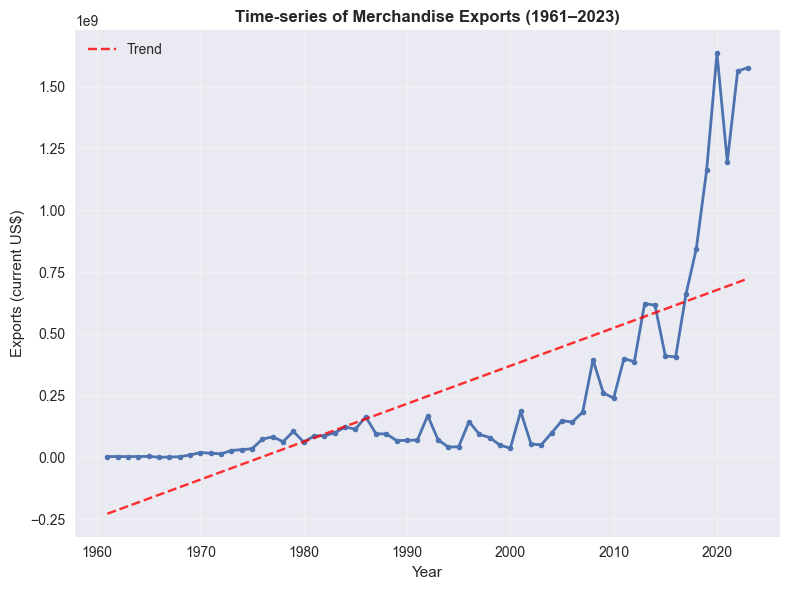

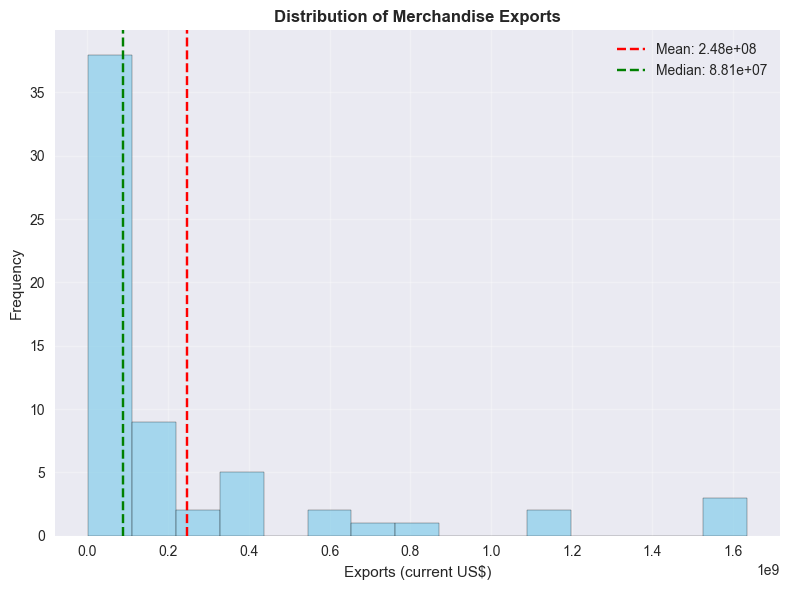

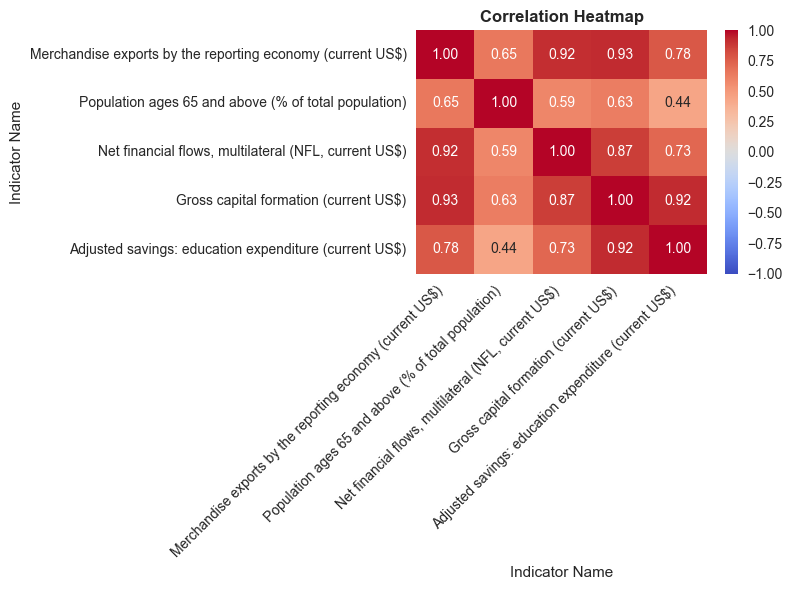

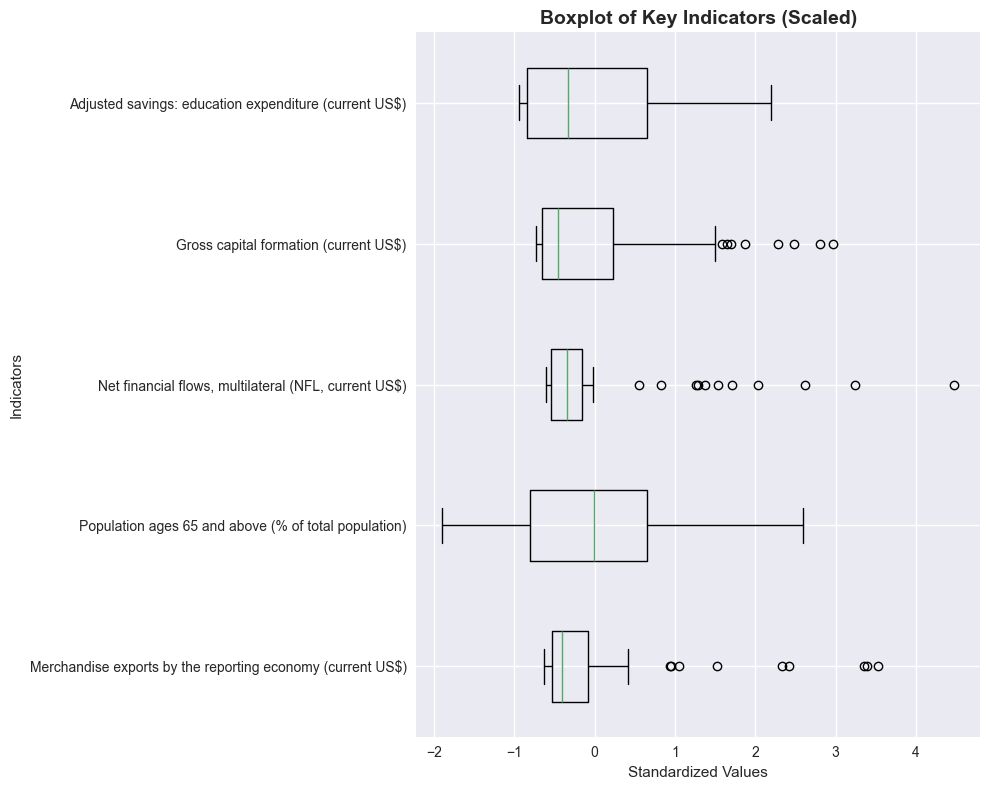


=== ENHANCED DATA PREPROCESSING ===
Original feature space: 377 features
Removed 213 highly correlated features
Reduced feature space: 164 features
PCA explained variance ratio: [0.32990931 0.16809673 0.10369128 0.07498099 0.05778908]
Total variance explained: 0.859

=== MODEL CONFIGURATIONS ===
1. Polynomial Regression:
   - Pipeline: PolynomialFeatures(degree=2) -> LinearRegression()
   - Feature Selection: SelectKBest(k=50, score_func=f_regression)
   - Input features: 50 selected features

2. Random Forest Classifier:
   - n_estimators: 50
   - random_state: 42
   - Input features: 164

3. KMeans Clustering:
   - n_clusters: 4
   - random_state: 42
   - n_init: 10
   - Input features: 164 (PCA-transformed to 2 components for visualization)

=== REGRESSION MODELING ===
Cross-validation results:
Polynomial Regression: r2 = 0.804 (+/- 0.140)

Test set evaluation:
Training Polynomial Regression...

Polynomial Regression Results:
  RMSE: 9.44e+07
  MAE: 5.27e+07
  R2: 0.616


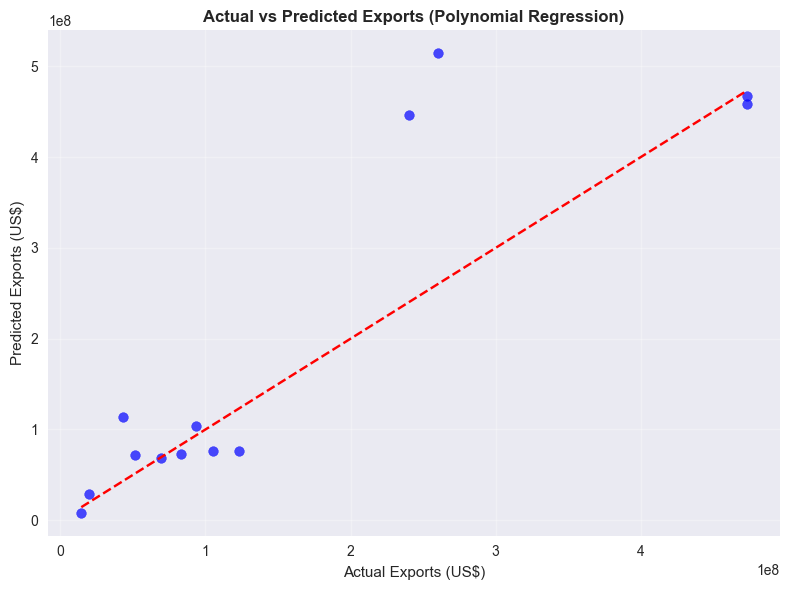


=== NEURAL NETWORK TRAINING ===
Neurons: 64, Learning Rate: 0.001, Mean R2: -1.063
Best parameters: {'neurons': 64, 'learning_rate': 0.001}, Best Mean R2: -1.063

4. Simplified DNN Configuration:
   - Neurons: 64 (first layer), 32 (second layer)
   - Learning Rate: 0.001
   - Layers: Dense(64, relu) -> BatchNorm -> Dropout(0.3) -> Dense(32, relu) -> BatchNorm -> Dropout(0.3) -> Dense(1, linear)
   - Input features: 10 (PCA-transformed)

Simplified DNN Results:
  RMSE: 1.18e+08
  MAE: 9.38e+07
  R2: 0.398


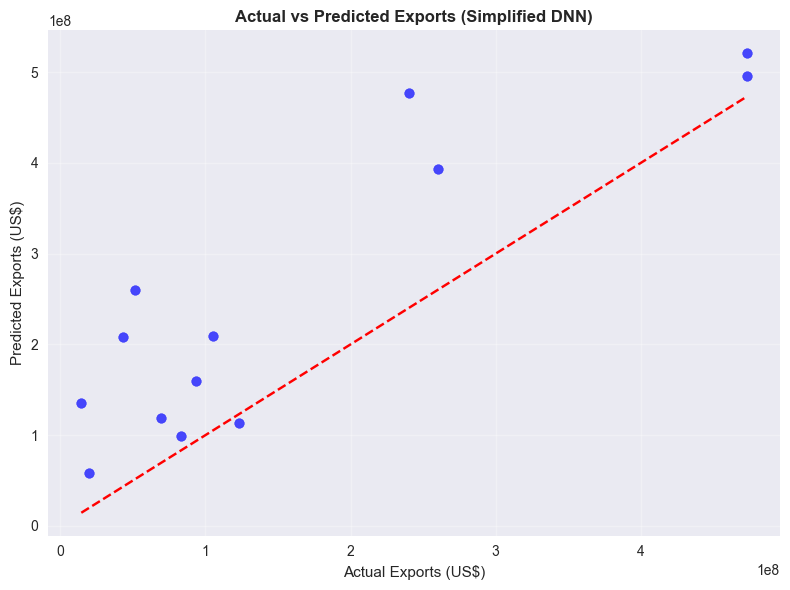


=== CLASSIFICATION MODELING ===
Cross-validation results (Accuracy):
Random Forest Classifier: accuracy = 0.800 (+/- 0.110)

Test set evaluation:
Training Random Forest Classifier...

Random Forest Classifier Results:
  Accuracy: 0.846
  F1-Score: 0.833

=== CONFUSION MATRIX ===


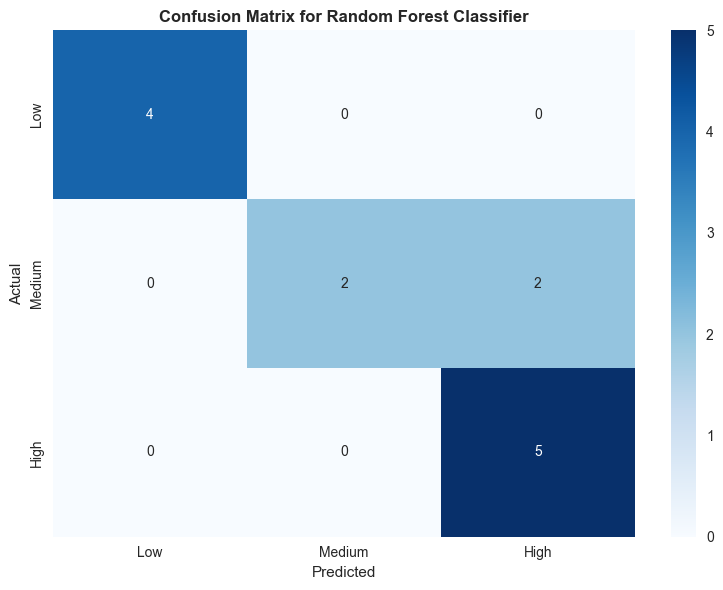


=== CLUSTERING ANALYSIS ===
K=2: Silhouette Score = 0.290, Calinski-Harabasz = 18.09
K=3: Silhouette Score = 0.246, Calinski-Harabasz = 16.72
K=4: Silhouette Score = 0.255, Calinski-Harabasz = 16.67
K=5: Silhouette Score = 0.282, Calinski-Harabasz = 16.84
K=6: Silhouette Score = 0.278, Calinski-Harabasz = 16.89


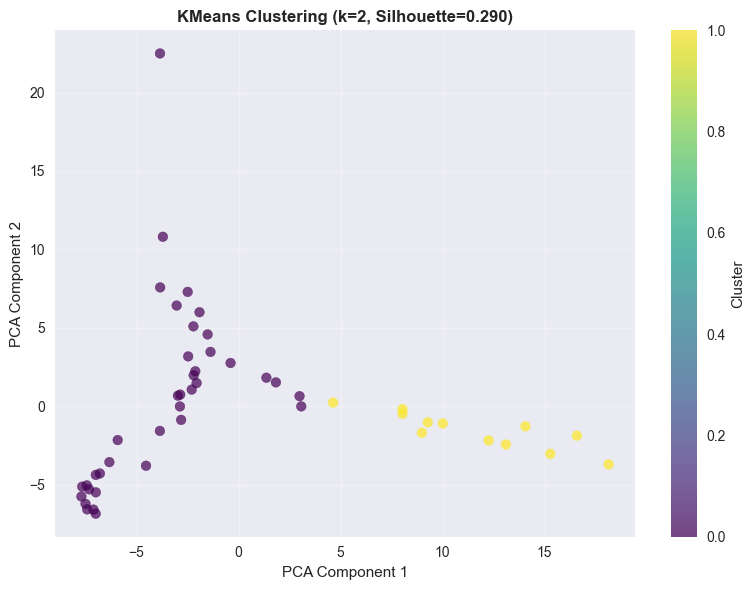


Cluster Periods:
   Cluster   min   max
0        0  1961  2007
1        1  2008  2023

Performance Summary Table:
                      Model  Primary Metric       Metric Type
0     Polynomial Regression        0.616143                R²
1            Simplified DNN        0.398079                R²
2  Random Forest Classifier        0.846154          Accuracy
3         KMeans Clustering        0.290272  Silhouette Score


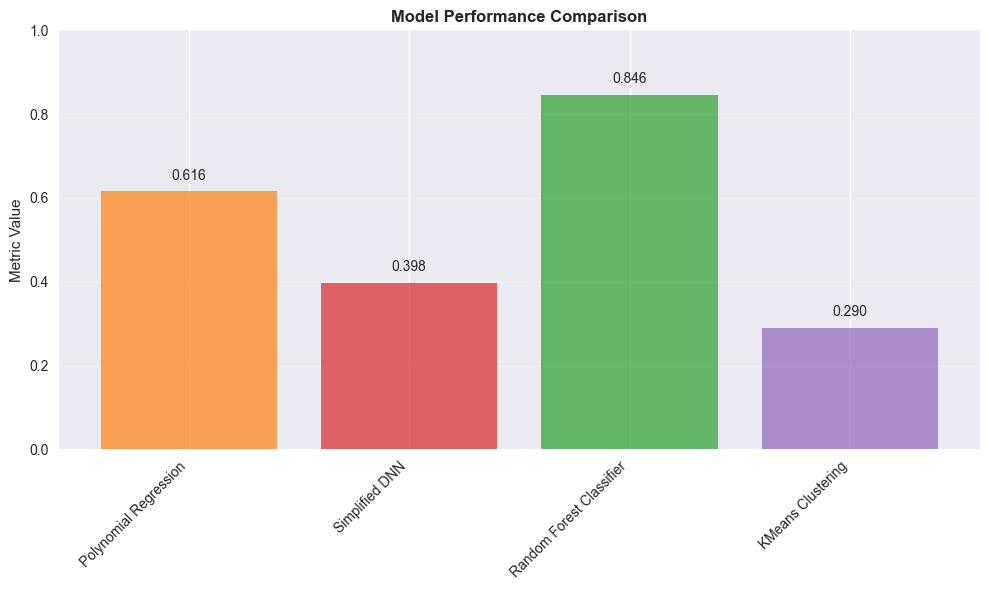


=== ANALYSIS SUMMARY ===
Dataset: 63 years, 378 original indicators
Processed: 50 selected features for regression

Regression Results:
  Polynomial Regression: R² = 0.616, RMSE = 9.44e+07
  Simplified DNN: R² = 0.398, RMSE = 1.18e+08

Classification Results:
  Random Forest Classifier: Accuracy = 0.846, F1 = 0.833

Clustering Results:
  Optimal clusters: 2
  Silhouette Score: 0.290


In [56]:
# 10: Main Analysis Pipeline
def main():
    """Main analysis pipeline to:
    1. Predict merchandise exports (regression and classification) using socioeconomic indicators.
    2. Identify distinct economic periods through clustering.
    Using exactly four models: Polynomial Regression, Random Forest Classifier, KMeans, Simplified DNN."""
    
    print("=== OPTIMIZED RWANDA DEVELOPMENT INDICATORS ANALYSIS ===\n")
    
    # Step 1: Load and clean data
    file_path = 'rwanda_socioeconomic_indicators.csv'
    df_wide = load_and_clean_data(file_path)
    
    if df_wide is None:
        print("Failed to load data. Exiting.")
        return
    
    print(f"\nDataset loaded successfully!")
    print(f"Shape: {df_wide.shape}")
    print(f"Years: {df_wide.index.min()} to {df_wide.index.max()}")
    
    # Step 2: EDA
    target_column = 'Merchandise exports by the reporting economy (current US$)'
    if target_column not in df_wide.columns:
        print(f"Target column '{target_column}' not found. Available columns:")
        print(df_wide.columns.tolist())
        return
    
    print(f"\n=== EXPLORATORY DATA ANALYSIS ===")
    key_indicators = perform_eda(df_wide, target_column)
    
    # Step 3: Enhanced preprocessing
    print(f"\n=== ENHANCED DATA PREPROCESSING ===")
    data = enhanced_preprocessing(df_wide, target_column)
    
    # Step 4: Define and print four models
    print(f"\n=== MODEL CONFIGURATIONS ===")
    regression_models = {
        'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    }
    classification_model = RandomForestClassifier(n_estimators=50, random_state=42)
    clustering_model = KMeans(n_clusters=4, random_state=42, n_init=10)
    
    # Print Polynomial Regression
    print("1. Polynomial Regression:")
    print("   - Pipeline: PolynomialFeatures(degree=2) -> LinearRegression()")
    print(f"   - Feature Selection: SelectKBest(k=50, score_func=f_regression)")
    print(f"   - Input features: {len(data['selected_features'])} selected features")
    
    # Print Random Forest Classifier
    print("\n2. Random Forest Classifier:")
    print(f"   - n_estimators: {classification_model.n_estimators}")
    print(f"   - random_state: {classification_model.random_state}")
    print(f"   - Input features: {data['X_train'].shape[1]}")
    
    # Print KMeans
    print("\n3. KMeans Clustering:")
    print(f"   - n_clusters: {clustering_model.n_clusters}")
    print(f"   - random_state: {clustering_model.random_state}")
    print(f"   - n_init: {clustering_model.n_init}")
    print(f"   - Input features: {data['X_train'].shape[1]} (PCA-transformed to 2 components for visualization)")
    
    # Step 5: Regression modeling
    print(f"\n=== REGRESSION MODELING ===")
    print("Cross-validation results:")
    cv_results = cross_validate_models(regression_models, data['X_train_selected'], data['y_train'])
    
    print("\nTest set evaluation:")
    regression_results = {}
    
    for name, model in regression_models.items():
        print(f"Training {name}...")
        model.fit(data['X_train_selected'], data['y_train'])
        results = evaluate_regression_model(model, data['X_test_selected'], data['y_test'], name)
        regression_results[name] = results
        
        # Plot actual vs predicted
        plt.figure(figsize=(8, 6))
        plt.scatter(data['y_test'], results['predictions'], alpha=0.7, color='blue')
        plt.plot([data['y_test'].min(), data['y_test'].max()], 
                 [data['y_test'].min(), data['y_test'].max()], 'r--')
        plt.title(f'Actual vs Predicted Exports ({name})', fontsize=12, fontweight='bold')
        plt.xlabel('Actual Exports (US$)')
        plt.ylabel('Predicted Exports (US$)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'figures/actual_vs_predicted_{name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Step 6: Neural network training
    print(f"\n=== NEURAL NETWORK TRAINING ===")
    dnn_model, best_params = train_neural_networks(data)
    
    # Print DNN configuration
    print(f"\n4. Simplified DNN Configuration:")
    print(f"   - Neurons: {best_params['neurons']} (first layer), {best_params['neurons']//2} (second layer)")
    print(f"   - Learning Rate: {best_params['learning_rate']}")
    print(f"   - Layers: Dense({best_params['neurons']}, relu) -> BatchNorm -> Dropout(0.3) -> Dense({best_params['neurons']//2}, relu) -> BatchNorm -> Dropout(0.3) -> Dense(1, linear)")
    print(f"   - Input features: {data['X_train_pca'].shape[1]} (PCA-transformed)")
    
    # Evaluate neural network
    dnn_results = evaluate_regression_model(
        dnn_model, data['X_test_pca'], data['y_test_scaled'], 
        "Simplified DNN", data['y_scaler']
    )
    regression_results["Simplified DNN"] = dnn_results
    
    # Plot actual vs predicted for DNN
    plt.figure(figsize=(8, 6))
    plt.scatter(data['y_test'], dnn_results['predictions'], alpha=0.7, color='blue')
    plt.plot([data['y_test'].min(), data['y_test'].max()], 
             [data['y_test'].min(), data['y_test'].max()], 'r--')
    plt.title('Actual vs Predicted Exports (Simplified DNN)', fontsize=12, fontweight='bold')
    plt.xlabel('Actual Exports (US$)')
    plt.ylabel('Predicted Exports (US$)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/actual_vs_predicted_dnn.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Step 7: Classification modeling
    print(f"\n=== CLASSIFICATION MODELING ===")
    print("Cross-validation results (Accuracy):")
    cv_class_results = cross_validate_models({'Random Forest Classifier': classification_model}, 
                                            data['X_train'], data['y_train_class'], scoring='accuracy')
    
    print("\nTest set evaluation:")
    print(f"Training Random Forest Classifier...")
    classification_model.fit(data['X_train'], data['y_train_class'])
    classification_results = evaluate_classification_model(classification_model, data['X_test'], 
                                                          data['y_test_class'], "Random Forest Classifier")
    
    # Confusion matrix
    print(f"\n=== CONFUSION MATRIX ===")
    cm = confusion_matrix(data['y_test_class'], classification_results['predictions'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.title('Confusion Matrix for Random Forest Classifier', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Step 8: Clustering analysis
    print(f"\n=== CLUSTERING ANALYSIS ===")
    cluster_results, best_n_clusters = enhanced_clustering_analysis(data['X_train'], data['y_train'], data['feature_names'])
    
    # Step 9: Performance comparison
    performance_data = {
        'Model': ['Polynomial Regression', 'Simplified DNN', 'Random Forest Classifier', 'KMeans Clustering'],
        'Primary Metric': [
            regression_results['Polynomial Regression']['R2'],
            regression_results['Simplified DNN']['R2'],
            classification_results['Accuracy'],
            cluster_results[best_n_clusters]['silhouette']
        ],
        'Metric Type': ['R²', 'R²', 'Accuracy', 'Silhouette Score']
    }
    performance_df = pd.DataFrame(performance_data)
    performance_df.to_csv('figures/performance_summary.csv', index=False)
    print("\nPerformance Summary Table:")
    print(performance_df)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(performance_df['Model'], performance_df['Primary Metric'], 
                   color=['#ff7f0e', '#d62728', '#2ca02c', '#9467bd'], alpha=0.7)
    plt.title('Model Performance Comparison', fontsize=12, fontweight='bold')
    plt.ylabel('Metric Value')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', 
                 ha='center', va='bottom')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Step 10: Summary
    print(f"\n=== ANALYSIS SUMMARY ===")
    print(f"Dataset: {df_wide.shape[0]} years, {df_wide.shape[1]} original indicators")
    print(f"Processed: {len(data['selected_features'])} selected features for regression")
    print(f"\nRegression Results:")
    for model, results in regression_results.items():
        print(f"  {model}: R² = {results['R2']:.3f}, RMSE = {results['RMSE']:.2e}")
    print(f"\nClassification Results:")
    print(f"  Random Forest Classifier: Accuracy = {classification_results['Accuracy']:.3f}, F1 = {classification_results['F1']:.3f}")
    print(f"\nClustering Results:")
    print(f"  Optimal clusters: {best_n_clusters}")
    print(f"  Silhouette Score: {cluster_results[best_n_clusters]['silhouette']:.3f}")

if __name__ == "__main__":
    main()